In [1]:
# load in data
import os
print('Starting in: ', os.getcwd())
os.chdir("../")
print('Current working directory: ', os.getcwd())

Starting in:  /Users/gbemidebe/Documents/GitHub/SolutionTransformer/notebook
Current working directory:  /Users/gbemidebe/Documents/GitHub/SolutionTransformer


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, EvalPrediction
from transformers import  Trainer, EvalPrediction
from transformers.training_args import TrainingArguments

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/Users/gbemidebe/miniconda3/envs/SolutionTransformer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load data

In [3]:
# load in data
data = pd.read_csv('data/processed/cleaned_Brouwer_2021.csv')

In [4]:
data.head()

,solute,solvent,T,log_gamma
0,C,CCCCCCCCCCCCCCCC,40.0,-0.261365
1,C,CCCCCCCCCCCCCCCC,70.0,-0.287682
2,C,CCCCCCCCCCCCCCCC,90.0,-0.301105
3,CC,CCCCCCCCCCCCCCCC,40.0,-0.235722
4,CC,CCCCCCCCCCCCCCCC,70.0,-0.248461


In [5]:
# rename columns
data.columns = ['solute', 'solvent', 'T', 'label']

# convert to dataset
dataset = Dataset.from_pandas(data, preserve_index=False)

# using split function to split dataset into train, test, and validation sets
train_testvalid = dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['solute', 'solvent', 'T', 'label'],
        num_rows: 16696
    })
    test: Dataset({
        features: ['solute', 'solvent', 'T', 'label'],
        num_rows: 2087
    })
    valid: Dataset({
        features: ['solute', 'solvent', 'T', 'label'],
        num_rows: 2087
    })
})

## 2. Tokenize the dataset

In [6]:
# load in the tokenizer
model_name = 'seyonec/PubChem10M_SMILES_BPE_450k'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# get maximum length of input sequence
def max_len(data, idx):
    """
    Returns the maximum length of the input sequence"""
    return max([len(x) for x in data[idx]])

maximum_length=max_len(data, "solute") + max_len(data, "solvent") + 3
print(maximum_length)

# tokenize function
def tokenize_function(examples):
    '''
    Tokenizes the input sequence'''
    return tokenizer(examples["solute"], examples["solvent"], padding='max_length', truncation=True, max_length=maximum_length)

tokenized_datasets = train_test_valid_dataset.map(tokenize_function, batched=True).remove_columns(["solute", 'solvent', 'T'])

train_data = tokenized_datasets["train"]
eval_data = tokenized_datasets["valid"]
test_data = tokenized_datasets['test']



136


Map: 100%|██████████| 2087/2087 [00:00<00:00, 21188.22 examples/s]


In [23]:
train_data

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 16696
})

## 3. Model Training

In [7]:
# configuration for regression
config = AutoConfig.from_pretrained(model_name,num_labels=1)
# load in the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config,)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def compute_metrics(output: EvalPrediction):
    """
    Computes the metrics for evaluation"""
    preds, labels = output

    return {
        "mse": mean_squared_error(labels, preds),
        "mae": mean_absolute_error(labels, preds),
        "r2": r2_score(labels, preds)}

In [9]:
# choose arguments for training
training_args = TrainingArguments(
    output_dir="./model/no_temp", 
    overwrite_output_dir=True, 
    num_train_epochs=10,
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    learning_rate=1e-4, evaluation_strategy="epoch", save_strategy="epoch", 
    do_train=True, do_eval=True, optim='adamw_torch', load_best_model_at_end=True,)

In [10]:
# trainer for training
trainer = Trainer(
    model=model, args=training_args, compute_metrics=compute_metrics,
    train_dataset=train_data, eval_dataset=eval_data,)

# train the model
trainer.train()

 10%|▉         | 500/5220 [05:08<46:45,  1.68it/s] 

{'loss': 0.8707, 'learning_rate': 9.042145593869731e-05, 'epoch': 0.96}


                                                    
 10%|█         | 522/5220 [05:38<1:50:54,  1.42s/it]

{'eval_loss': 0.3382129371166229, 'eval_mse': 0.3382129669189453, 'eval_mae': 0.3686157166957855, 'eval_r2': 0.9219569659438904, 'eval_runtime': 14.5507, 'eval_samples_per_second': 143.429, 'eval_steps_per_second': 4.536, 'epoch': 1.0}


 19%|█▉        | 1000/5220 [10:47<43:48,  1.61it/s] 

{'loss': 0.3068, 'learning_rate': 8.084291187739465e-05, 'epoch': 1.92}


                                                   
 20%|██        | 1044/5220 [11:27<42:46,  1.63it/s]

{'eval_loss': 0.23967863619327545, 'eval_mse': 0.23967863619327545, 'eval_mae': 0.3173563778400421, 'eval_r2': 0.9446938713639481, 'eval_runtime': 11.747, 'eval_samples_per_second': 177.662, 'eval_steps_per_second': 5.618, 'epoch': 2.0}


 29%|██▊       | 1500/5220 [15:54<33:42,  1.84it/s]  

{'loss': 0.2417, 'learning_rate': 7.126436781609196e-05, 'epoch': 2.87}


                                                   
 30%|███       | 1566/5220 [16:41<31:10,  1.95it/s]

{'eval_loss': 0.2191343903541565, 'eval_mse': 0.2191344052553177, 'eval_mae': 0.2844679653644562, 'eval_r2': 0.9494344780966644, 'eval_runtime': 10.2826, 'eval_samples_per_second': 202.964, 'eval_steps_per_second': 6.419, 'epoch': 3.0}


 38%|███▊      | 2000/5220 [20:54<29:47,  1.80it/s]  

{'loss': 0.1915, 'learning_rate': 6.168582375478928e-05, 'epoch': 3.83}


                                                   
 40%|████      | 2088/5220 [21:53<26:41,  1.96it/s]

{'eval_loss': 0.17989249527454376, 'eval_mse': 0.17989248037338257, 'eval_mae': 0.27163469791412354, 'eval_r2': 0.9584895977453435, 'eval_runtime': 10.4134, 'eval_samples_per_second': 200.416, 'eval_steps_per_second': 6.338, 'epoch': 4.0}


 48%|████▊     | 2500/5220 [25:55<25:49,  1.75it/s]  

{'loss': 0.1569, 'learning_rate': 5.2107279693486586e-05, 'epoch': 4.79}


                                                   
 50%|█████     | 2610/5220 [27:08<21:34,  2.02it/s]

{'eval_loss': 0.15638916194438934, 'eval_mse': 0.15638914704322815, 'eval_mae': 0.252327024936676, 'eval_r2': 0.9639130170912421, 'eval_runtime': 9.8877, 'eval_samples_per_second': 211.069, 'eval_steps_per_second': 6.675, 'epoch': 5.0}


 57%|█████▋    | 3000/5220 [30:44<23:05,  1.60it/s]  

{'loss': 0.1396, 'learning_rate': 4.252873563218391e-05, 'epoch': 5.75}


                                                   
 60%|██████    | 3132/5220 [32:07<18:01,  1.93it/s]

{'eval_loss': 0.16059871017932892, 'eval_mse': 0.16059868037700653, 'eval_mae': 0.24839606881141663, 'eval_r2': 0.9629416651009277, 'eval_runtime': 9.9333, 'eval_samples_per_second': 210.101, 'eval_steps_per_second': 6.644, 'epoch': 6.0}


 67%|██████▋   | 3500/5220 [35:27<15:15,  1.88it/s]  

{'loss': 0.1267, 'learning_rate': 3.295019157088123e-05, 'epoch': 6.7}


                                                   
 70%|███████   | 3654/5220 [36:59<13:03,  2.00it/s]

{'eval_loss': 0.1679796278476715, 'eval_mse': 0.1679796278476715, 'eval_mae': 0.27231255173683167, 'eval_r2': 0.961238504275814, 'eval_runtime': 9.7467, 'eval_samples_per_second': 214.123, 'eval_steps_per_second': 6.772, 'epoch': 7.0}


 77%|███████▋  | 4000/5220 [40:06<10:46,  1.89it/s]  

{'loss': 0.1107, 'learning_rate': 2.3371647509578545e-05, 'epoch': 7.66}


                                                   
 80%|████████  | 4176/5220 [41:50<08:42,  2.00it/s]

{'eval_loss': 0.13243278861045837, 'eval_mse': 0.13243278861045837, 'eval_mae': 0.19708164036273956, 'eval_r2': 0.9694409771715019, 'eval_runtime': 9.7334, 'eval_samples_per_second': 214.416, 'eval_steps_per_second': 6.781, 'epoch': 8.0}


 86%|████████▌ | 4500/5220 [44:48<06:16,  1.91it/s]  

{'loss': 0.0929, 'learning_rate': 1.3793103448275863e-05, 'epoch': 8.62}


                                                   
 90%|█████████ | 4698/5220 [46:42<04:21,  2.00it/s]

{'eval_loss': 0.12983180582523346, 'eval_mse': 0.12983180582523346, 'eval_mae': 0.21097224950790405, 'eval_r2': 0.9700411594434215, 'eval_runtime': 9.4842, 'eval_samples_per_second': 220.049, 'eval_steps_per_second': 6.959, 'epoch': 9.0}


 96%|█████████▌| 5000/5220 [49:23<01:54,  1.92it/s]

{'loss': 0.0896, 'learning_rate': 4.214559386973181e-06, 'epoch': 9.58}


                                                   
100%|██████████| 5220/5220 [51:29<00:00,  2.01it/s]

{'eval_loss': 0.12013041973114014, 'eval_mse': 0.12013043463230133, 'eval_mae': 0.19063104689121246, 'eval_r2': 0.9722797618422815, 'eval_runtime': 9.6455, 'eval_samples_per_second': 216.369, 'eval_steps_per_second': 6.843, 'epoch': 10.0}


100%|██████████| 5220/5220 [51:31<00:00,  1.69it/s]

{'train_runtime': 3091.9262, 'train_samples_per_second': 53.999, 'train_steps_per_second': 1.688, 'train_loss': 0.22659628126356338, 'epoch': 10.0}


TrainOutput(global_step=5220, training_loss=0.22659628126356338, metrics={'train_runtime': 3091.9262, 'train_samples_per_second': 53.999, 'train_steps_per_second': 1.688, 'train_loss': 0.22659628126356338, 'epoch': 10.0})

In [11]:
# evaluate on the validation set
trainer.evaluate()


100%|██████████| 66/66 [00:09<00:00,  7.22it/s]


{'eval_loss': 0.12013041973114014,
 'eval_mse': 0.12013043463230133,
 'eval_mae': 0.19063104689121246,
 'eval_r2': 0.9722797618422815,
 'eval_runtime': 9.3091,
 'eval_samples_per_second': 224.189,
 'eval_steps_per_second': 7.09,
 'epoch': 10.0}

## 4. Model Testing

In [12]:
# predict on the train, test and validation set
predictions_train = trainer.predict(train_data)
predictions_test = trainer.predict(test_data)
predictions_valid = trainer.predict(eval_data)

100%|██████████| 66/66 [00:09<00:00,  7.05it/s]


In [13]:
import matplotlib.pyplot as plt

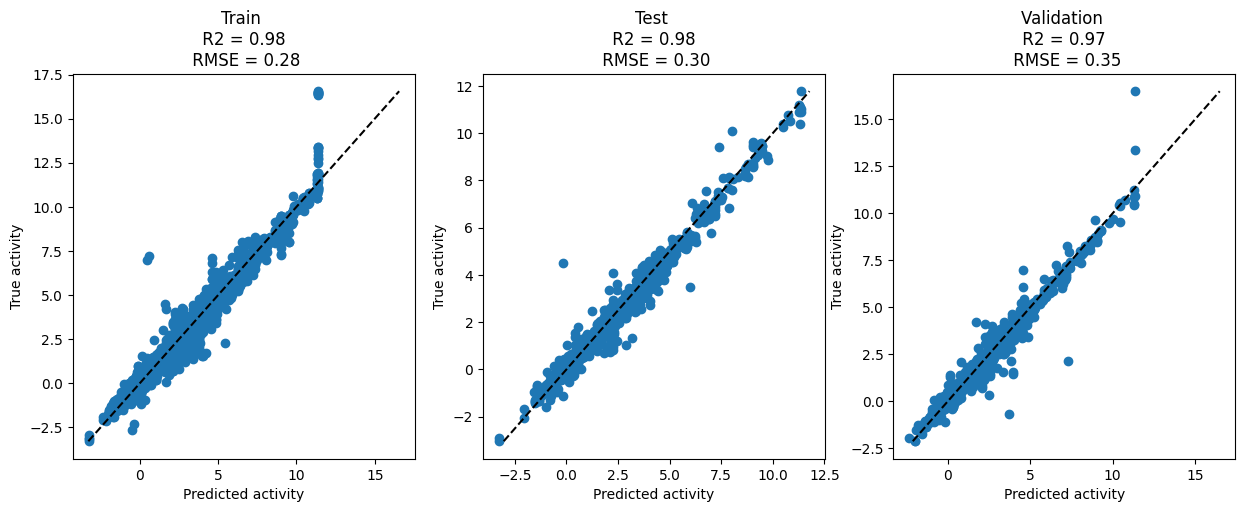

In [22]:
# plot the predictions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# train
ax[0].scatter(predictions_train.predictions, predictions_train.label_ids)
ax[0].plot([min(predictions_train.label_ids), max(predictions_train.label_ids)], [min(predictions_train.label_ids), max(predictions_train.label_ids)],  ls='--', c='k')
ax[0].set_xlabel('Predicted activity')
ax[0].set_ylabel('True activity')
ax[0].set_title('Train \n R2 = {r2:.2f} \n RMSE = {rmse:.2f}'.format(r2=r2_score(predictions_train.label_ids, predictions_train.predictions), rmse=np.sqrt(mean_squared_error(predictions_train.label_ids, predictions_train.predictions)))) 

# test
ax[1].scatter(predictions_test.predictions, predictions_test.label_ids)
ax[1].plot([min(predictions_test.label_ids), max(predictions_test.label_ids)], [min(predictions_test.label_ids), max(predictions_test.label_ids)],  ls='--', c='k')
ax[1].set_xlabel('Predicted activity')
ax[1].set_ylabel('True activity')
ax[1].set_title('Test \n R2 = {r2:.2f} \n RMSE = {rmse:.2f}'.format(r2=r2_score(predictions_test.label_ids, predictions_test.predictions), rmse=np.sqrt(mean_squared_error(predictions_test.label_ids, predictions_test.predictions))))

# validation
ax[2].scatter(predictions_valid.predictions, predictions_valid.label_ids)
ax[2].plot([min(predictions_valid.label_ids), max(predictions_valid.label_ids)], [min(predictions_valid.label_ids), max(predictions_valid.label_ids)],  ls='--', c='k')
ax[2].set_xlabel('Predicted activity')
ax[2].set_ylabel('True activity')
ax[2].set_title('Validation \n R2 = {r2:.2f} \n RMSE = {rmse:.2f}'.format(r2=r2_score(predictions_valid.label_ids, predictions_valid.predictions), rmse=np.sqrt(mean_squared_error(predictions_valid.label_ids, predictions_valid.predictions))))

plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print('R2 score: ', r2_score(predictions.label_ids, predictions.predictions))
print('MAE: ', mean_absolute_error(predictions.label_ids, predictions.predictions))
print('MSE: ', mean_squared_error(predictions.label_ids, predictions.predictions))
